# A) This notebook offers a comprehensive tutorial on WE data analysis with minimal user input, using the HDF5 file format generated by Wepy.

# B) No prior knowledge about the HDF5 file is needed to run the notebook. But for more details, look at the wepy documentation.

### https://adicksonlab.github.io/wepy/_source/tutorials/data_analysis/hdf5_access/README.html

In [1]:
from wepy.hdf5 import WepyHDF5
from wepy.analysis.parents import resampling_panel, parent_panel, net_parent_table, ancestors
from wepy.resampling.decisions.clone_merge import MultiCloneMergeDecision
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

### First load & open the HDF5 file named "wepy.results.h5" with "read" mode. Also provide the time interval between cycles i.e number of MD steps * MD integration time step.

In [2]:
wepy_h5 = WepyHDF5('simdata_run1_steps10000_cycs20000/wepy.results.h5', mode='r')
delta_t = 20  # Time interval between cycles in ps.
wepy_h5.open()

### To extract & display the necessary informations from the HDF5 file for convergence check & MFPT calculation, run the following cell. 

In [3]:
# Print all the basic informations related to the WE simulations
n_walkers = wepy_h5.num_init_walkers(0)       # Number of walkers
warped_walker_idxs = [i[0] for i in list(wepy_h5.h5['/runs/0/warping/walker_idx'])]   # Warped walker ids
cycle_idxs = np.array(list(wepy_h5.h5['/runs/0/warping/_cycle_idxs']))                # Corresponding ids
w_i = wepy_h5.h5['/runs/0/warping/weight']    # weights of the walkers when they reached the target state for the first time
w_i = np.array([i[0] for i in w_i])
T_list = (cycle_idxs*delta_t*0.001*n_walkers)       # Cumulative simulation time points in ns when walkers reach the target



print('Number of walkers:', n_walkers, '\n')
print('Cycle indices when the walkers reach the target:\n', cycle_idxs, '\n')
print('Indices of the walkers who reach the target (warped walkers):\n', warped_walker_idxs, '\n')
print('Weights of the warped walkers:\n', w_i, '\n')
print('Cumulative simulation time points (ns) when walkers reach the target:\n', T_list, '\n')
print(f'For example: Walker {warped_walker_idxs[0]} reached the target at {cycle_idxs[0]}th cycle with weight {w_i[0]}.')

Number of walkers: 24 

Cycle indices when the walkers reach the target:
 [  48   48   51   53   54   54   56   56   57   60   61   63   64   64
   65   66   72   74   75   81   82   87   94   96  107  121  124  125
  127  137  156  159  160  164  169  169  171  171  177  185  193  262
  267  290  328  398  403  425  426  428  438  441  452  462  463  467
  472  477  491  607  769  797  807  820  935  959  992 1000 1028 1029
 1049 1066 1076 1184 1191 1194 1197] 

Indices of the walkers who reach the target (warped walkers):
 [3, 21, 10, 15, 10, 18, 10, 23, 23, 18, 7, 7, 8, 23, 23, 3, 20, 7, 19, 16, 3, 8, 14, 8, 17, 2, 9, 15, 23, 6, 9, 19, 10, 19, 9, 16, 8, 19, 15, 10, 16, 17, 15, 18, 22, 6, 18, 15, 15, 13, 18, 17, 15, 13, 17, 6, 6, 15, 6, 6, 12, 19, 15, 23, 17, 17, 12, 12, 13, 12, 23, 3, 19, 6, 15, 18, 13] 

Weights of the warped walkers:
 [1.41904957e-17 1.84476445e-16 1.41904957e-17 1.41904957e-17
 9.22382223e-17 7.09524787e-18 1.43481679e-16 1.43481679e-16
 4.78272264e-17 2.39136132

### To check convergence, run the following cell. All the necessary informations and the aggregated cumulative probability plot will be printed.

Number of events observed: 71 

First event occured at (ns): 23.04 , Last event occured at (ns): 574.5600000000001 



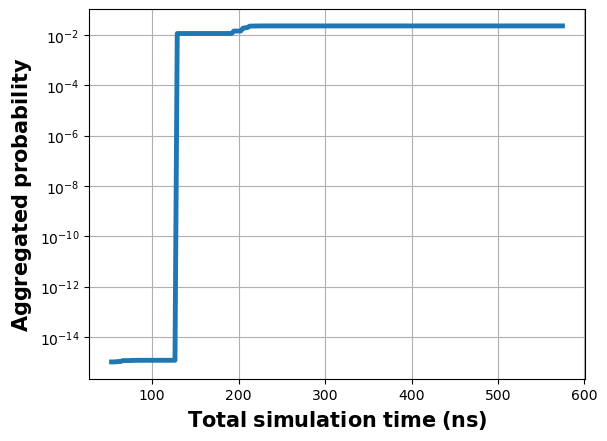

In [4]:
# Those walkers with weights less than the initial assigned weights reach the target will be accepted
# and weights of other walkers will be rejected when calculating cumulative weights
w_accept = np.array([weight for weight in w_i if weight < 1/n_walkers])
w_reject = np.array([weight for weight in w_i if weight >= 1/n_walkers])
print('Number of events observed:', len(w_accept), '\n')


# Identify those rejected walkers
idxs = np.unique(np.concatenate([np.where(w_i == element)[0] for element in w_reject]))



# Remove the time points corresponding to the rejected walkers form the T_list
T_list = np.delete(T_list, idxs)


# Print the time when the first and the last accepted events observed 
print('First event occured at (ns):', T_list[0], ', Last event occured at (ns):', T_list[-1], '\n')


# Generate a uniform time list to calculate and plot the cumulative prabability vs time
time_list = np.linspace(T_list[0]+30, T_list[-1], num=200, endpoint=True) # ns


# Cumulative sum of probabilities
csp = [] 

for time_value in time_list:
    j = np.max(np.where(T_list <= time_value)[0])
    csp.append(np.sum(w_accept[:j+1]))
    

# Plot the data
fig, ax = plt.subplots()
ax.plot(time_list, csp, lw=3.5)

ax.set_ylabel(r'$\mathbf{Aggregated\;probability}$', fontsize=15)
ax.set_xlabel(r'$\mathbf{Total\;simulation\;time\;(ns)}$', fontsize=15)
ax.set_yscale("log")
ax.grid('y axis')


# Always close the HDF5 file after operations
wepy_h5.close()

### Is the data converged ? If "yes", calculate MFPT by running the following cell.

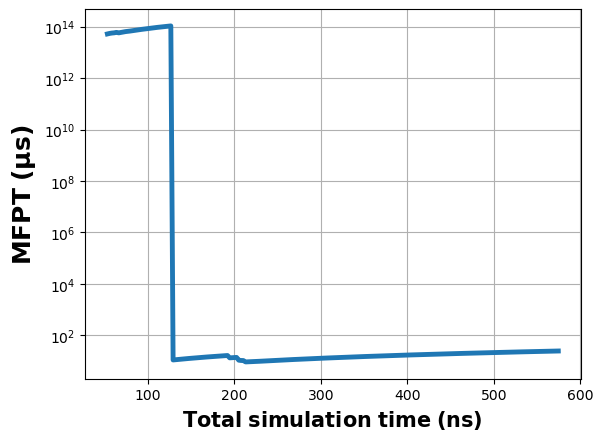

In [5]:
# MFPT calculation according to the eq.2 of the manuscript
mfpt = (time_list/np.array(csp))*0.001      # in micro sec


# Plot
fig, ax = plt.subplots()
ax.plot(time_list, mfpt, lw=3.5)

ax.set_ylabel(r'$\mathbf{MFPT \;(\mu s)}$', fontsize=18)
ax.set_xlabel(r'$\mathbf{Total\;simulation\;time\;(ns)}$', fontsize=15)
ax.set_yscale("log")
ax.grid('y axis')

### Save the data

In [6]:
df = pd.DataFrame()
df['#time(ns)'] = time_list
df['agg prob.'] = csp
df['MFPT (micro sec)'] = mfpt
df.to_csv('data.txt', columns=['#time(ns)', 'agg prob.',  'MFPT (micro sec)'], sep='\t', index=None)

### To generate WE productive trajectory (.xtc format), run the following cell with two user defined inputs: 1) Any walker id that reach the target. 2) The corresponding cycle id when that walker reach the target.

### Caution: Time step of the trajectory will be wrong. Change the time step using gmx trjconv -timestep .

In [7]:
############# User defined part #################

walker_id =  3      
cycle_id =  48       

#################################################



wepy_h5.open()
output_file = f'cycle{cycle_id}_walker{walker_id}_productive_traj.xtc'

all_ancestors = []
mod_ances = []

run_idx = 0
    
# Resampling record has information of cloning/merging/squashing/keeping  
resamp_rec = wepy_h5.resampling_records([run_idx])
resamp_panel = resampling_panel(resamp_rec)
par_panel = parent_panel(MultiCloneMergeDecision, resamp_panel)
net_par_table = net_parent_table(par_panel)
 
ances = ancestors(net_par_table, cycle_id, walker_id)
for element in ances:
    mod_ances.append([run_idx, element[0], element[1]])

all_ancestors.append(mod_ances)

# Making trajectory
traj_trace = []
for element in all_ancestors[0]:
    traj_trace.append(tuple(element))
    
traj = wepy_h5.trace_to_mdtraj(traj_trace)
traj.save_xtc(output_file)


print("Frames extraction completed in .xtc format....")

# Always close the HDF5 file after operations
wepy_h5.close()

Frames extraction completed in .xtc format....
